### Training PGVAE on toy MNIST dataset
This script is different from `../scripts/run_mbo.py` in the following ways,
1) Architecture of encoder and decoder for mnist have been added (lines 127-132) \
2) `data_type set` to `"image_mnist"` as the train set (toy_mnist.npz) does not contain orc_spec (lines 88-93) \
3) There is no oracle defined for mnist as it is only used to study the latent space of PPGVAE \
4) If the training is performed with other weighting based methods `weighted_opt_firststep` should be set to \
   `True` otherwise a vanilla VAE will be trained (lines 43-44)

In [2]:
import os
import sys
sys.path.append("../scripts")

from os.path import basename

import torch
import numpy as np
import pandas as pd

import json
import itertools

from tch_utils import BatchRNG, BMLP
from ds_utils import Dataset, save_ds, get_unique_quantile
from mbo_utils import weight_generator
from pgvae import copy_module, loss_function, \
                  forward, sample_comprehensive

In [3]:
class Oracle_image():
    def __init__(self, name="img"):
        self.name = name
    def __call__(self, x, y):
        # uses y as the scores
        orc_dict = {"x_raw": x, "y": y}
        return orc_dict

In [6]:
use_argparse = False
if use_argparse:
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--run_config', action='store', type=str, required=True, 
                        help="path to file containing running config")
    args = parser.parse_args()
    run_config = args.run_config
else:
    run_config = "../configs/mnist_config.json"
    
    
with open(run_config) as f:
    run_config_dict = json.load(f)
    
ds_rootdir = run_config_dict["ds_rootdir"]
dss = run_config_dict["ds_names"] # ["ds1.npz", "ds2.npz"]
dss = [f"{ds_rootdir}/{ds}" for ds in dss]

method_names = run_config_dict["method_names"] #["pgvae", "dbas", "cbas", "rwr", "cem-pi"]
weighted_opt_firststeps = run_config_dict.get("weighted_opt_firststeps", [False]) #[False]
n_samples_gens = run_config_dict.get("n_samples_gens", [100]) #gmm: [100, 200]
savedir = run_config_dict["savedir"] #"results"
vae_type = run_config_dict["vae_type"] #"mlp" # later "cnn" ...
n_seeds = run_config_dict.get("n_seeds", 1) # 20
mbo_steps = run_config_dict.get("mbo_steps", 1) # mbo rounds

# generating the configs
cfg_lists = [dss, method_names, weighted_opt_firststeps, n_samples_gens]
cfgs = list(itertools.product(*cfg_lists))
print(f"number of configs {len(cfgs)}")


for cfg_it, cfg in enumerate(cfgs):
    datadir, method_name, weighted_opt_firststep, n_samples_gen = cfg
    ds_name = basename(datadir).split(".npz")[0]
    print(cfg)
    
    if (method_name == "pgvae" or method_name == "cbas") and weighted_opt_firststep:
        print("weighted optimization is not valid for pgvae and it is not valid for cbas in the first step")
        break
        
    if not(method_name in ["pgvae", "cbas"]):
        weighted_opt_firststep = True
    
    tch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tch_dtype = torch.float32

    os.makedirs(savedir, exist_ok=True)

    # temporary, weighted batch with torch not es2 code
    tch_gen = torch.Generator(tch_device)
    tch_gen.manual_seed(12345)

    #########################################################
    ########### Constructing the Batch RNG Object ###########
    #########################################################

    seed_start, seed_step = 10000, 200
    seed_end = seed_start + n_seeds*seed_step
    seed_arr = np.arange(seed_start, seed_end, seed_step)
    brng = BatchRNG(shape=(n_seeds,), lib="torch", 
                    device=tch_device, dtype=tch_dtype,
                    unif_cache_cols=1_000_000,
                    norm_cache_cols=5_000_000)
    brng.seed(seed_arr)

    ##############################################
    ########### Constructing the Dataset #########
    ##############################################

    rng_seed = 1234
    srng = np.random.default_rng(rng_seed)
    np.random.seed(rng_seed)

    # adding weights for optimization depends on the method
    add_w_optm = not(method_name == "pgvae")
    max_hist = None
    split_ratios = [1., 0., 0.]

    #############################################
    #### Read Data and Oracle Specifications ####
    #############################################
    
    
    # For mnist the train set does not include orc_spec,
    # as it is only used to study the latent space characteristic of PPGAVE
    data_type = "image_mnist"
    if False:
        data_spec = np.load(datadir, allow_pickle=True)
        orc_spec = data_spec["orc_spec"].reshape(-1)[0] # fix this later
        print("Oracle Specs\n", orc_spec)
        data_type = orc_spec["data_type"] # "image", "protein", "pinn", "gmm"
    criterion = "ce" if data_type == "protein" else "mse"

    if data_type in ["protein", "pinn", "gmm", "image_mnist"]:
        ds = Dataset(datadir=datadir, 
                     data_type=data_type, dtype=tch_dtype, 
                     device=tch_device, split_rng=srng, 
                     batch_rng=brng, split_ratios=split_ratios, 
                     add_w_optm=add_w_optm, name=ds_name, 
                     max_hist=max_hist, shuffle=False)
    else:
        raise NotImplementedError

    ##############################################
    ########### Constructing the Model ###########
    ##############################################

    ns, nds, *rds = ds.ds["x"].shape
    ldim_dict = {"protein": 20, "gmm": 2, "pinn": 10, "image_mnist": 2} 
    mlp_hdim_dict = {"protein": [64], "gmm": [64, 64], "pinn": [64], "image_mnist": [512, 256]}
    ldim = ldim_dict[data_type] # shared among all vae type
    if vae_type == "mlp":
        indim = np.prod(rds)
        outdim = ldim*2 # both mu and logvar
        mlp_hdim = mlp_hdim_dict[data_type]
        
        if data_type != "image_mnist":
            encoder = BMLP(indim=indim, hidden_dims=mlp_hdim, outdim=outdim, 
                           activation="lrelu", shape=(n_seeds, ), 
                           batch_rng=brng, use_sigmoid=False)
            decoder = BMLP(indim=ldim, hidden_dims=mlp_hdim[::-1], outdim=indim, 
                           activation="lrelu", shape=(n_seeds, ), 
                           batch_rng=brng, use_sigmoid=False)
        else:
            encoder = BMLP(indim=indim, hidden_dims=mlp_hdim, outdim=outdim, 
                           activation="relu", shape=(n_seeds, ), 
                           batch_rng=brng, use_sigmoid=False)
            decoder = BMLP(indim=ldim, hidden_dims=mlp_hdim[::-1], outdim=indim, 
                           activation="relu", shape=(n_seeds, ), 
                           batch_rng=brng, use_sigmoid=True)
            
        encoder.to(tch_device)
        decoder.to(tch_device)
    else:
        # later add cnn
        raise NotImplementedError

    # used in cbas weight generation (MBO)
    encoder_prior, decoder_prior = None, None

    ###################################
    ##### Optimization Parameters #####
    ###################################

    lr = 0.001
    batch_size = 256 if data_type in ["protein", "pinn"] else 128
    sample_strategy = "det"
    criterion = "ce" if data_type == "protein" else "mse"
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr)
    temperature = 5

    # training loop settings
    global_iter = 0 # training and mbo steps combined
    epochs = 10000

    #########################
    #### sampling setting ###
    #########################

    sample_mode = "condx_prior_scored" if method_name == "pgvae" else "random"
    std_scale = temperature**0.5 if method_name == "pgvae" else 1.

    #########################
    ###### MBO settings #####
    #########################

    rwr_alpha = 1.
    q_dbas = 0.95
    q_cem_pi = 0.95
    q_cbas = 0.95
    y_star = -(1e10)*torch.ones((n_seeds, 1), device=tch_device) if method_name in ("cbas", "dbas") else None
    w_optm_cutoff = 1e-06
    sigma_y_noise = 0.01


    ###################################
    ###### loss related settings ######
    ###################################

    kld_weight = 0.01 if data_type != "image_mnist" else 0.005
    rel_weight = 1. if method_name == "pgvae" else 0.

    #######################
    ### Oracle settings ###
    #######################

    # protein_gt oracle
    if data_type == "protein":
        from oracles import Oracle_protein_gt
        ns, xs, seq_len, num_cls = ds.ds["x"].shape
        orc_path = orc_spec["orc_path"] # path to the oracle
        print(f"load oracle from {orc_path}")
        orc = Oracle_protein_gt(orc_path=orc_path, seq_len=seq_len, 
                                num_cls=num_cls, device=tch_device, name=ds_name)
    elif data_type == "gmm":
        from oracles import Oracle_gmm
        mu_2nd = orc_spec["mu_2nd"] # [4, ..., 30]
        mu_1st = orc_spec["mu_1st"]
        mu_shift = orc_spec["mu_shift"]
        xd, n_gmm = orc_spec["xd"], orc_spec["n_gmm"]
        mu_2nd = mu_2nd + mu_shift
        mu_1st = mu_1st + mu_shift
        mus_gmm = [mu_1st*torch.ones(1, xd), mu_2nd*torch.ones(1, xd)]
        mus = torch.cat(mus_gmm, dim=0).to(tch_device)
        assert mus.shape == (n_gmm, xd)

        sigmas_gmm = orc_spec["sigmas_gmm"]
        sigmas_gmm = torch.tensor(sigmas_gmm) # sigma_gmms = [.25, 1.]
        sigmas = sigmas_gmm.reshape(-1, 1).broadcast_to(n_gmm, xd).to(tch_device)
        weights = orc_spec["weights"] # weights = [1., 2.5]
        weights = torch.tensor(weights).to(tch_device)
        assert weights.shape == (n_gmm,)

        orc = Oracle_gmm(mus=mus, sigmas=sigmas, weights=weights)
    elif data_type == "pinn":
        from oracles import Oracle_pinn
        orc_path = "../datasets/pinn_poisson.npz"
        orc = Oracle_pinn(orc_path, tch_dtype, tch_device)
    elif data_type == "image_mnist":
        orc = Oracle_image()
    else:
        assert NotImplementedError

    if weighted_opt_firststep:
        if not method_name in ["pgvae", "cbas"]:
            x_ds = ds.ds["x"]
            ns, xs, *xd = x_ds.shape
            if data_type == "protein":
                seq_len, num_cls = xd
            else:
                seq_len = num_cls = None

            #y_tr = ds.ds["y"][:, ds.train_inds]
            max_tr_y = None
            y_ds = ds.ds["y"]
            if method_name == "cem-pi":
                tr_unq_mask = ds.get_split_unique_mask()[0] # unique mask for train set
                assert y_ds.shape == (ns, xs)
                y_tr = y_ds*tr_unq_mask
                assert y_tr.shape == (ns, xs)
                max_tr_y, _ = torch.max(y_tr, dim=-1)
                assert max_tr_y.shape == (n_seeds,)

            w_optim_kwargs = dict(rwr_alpha=rwr_alpha, q_dbas=q_dbas, q_cem_pi=q_cem_pi, 
                                  q_cbas=q_cbas, y_star=y_star, max_tr_y=max_tr_y, 
                                  seq_len=seq_len, num_cls=num_cls, sigma_y_noise=sigma_y_noise, 
                                  encoder=encoder, decoder=decoder, encoder_prior=encoder_prior, 
                                  decoder_prior=decoder_prior)
            x_ds = x_ds.reshape(ns, xs, np.prod(xd))
            w_optim_kwargs["x"] = x_ds
            w_optim_kwargs["batch_rng"] = brng
            w_optm_gen, y_star = weight_generator(y_ds, method_name, criterion, **w_optim_kwargs)
            w_optm_gen[w_optm_gen < w_optm_cutoff] = 0. # probably unnecessary, remove later
            assert w_optm_gen.shape == (n_seeds, xs)

            ############################################################
            ##### Create a new dataset with generated samples added ####
            ############################################################

            # created a dataset of generated samples
            ds_upd = {"x": ds.ds["x"], "y": ds.ds["y"], "w_optm": w_optm_gen}
            ds.update(ds_upd)

         
    ########################
    ##### Training Loop ####
    ########################
    
    # MBO
    for mbo_step in range(mbo_steps):
        print(f"\nmbo step {mbo_step}")

        save_dict = dict(orc_spec=None, method_name=method_name, 
                         datadir=datadir, n_samples_gen=n_samples_gen, 
                         weighted_opt_firststep=weighted_opt_firststep, cfg_it=cfg_it)
        os.makedirs(f"{savedir}", exist_ok=True)
        save_ds(ds.dsall, f"{savedir}/rs{cfg_it}.pt", **save_dict)

        running_loss = 0.
        # get the train set size
        w_tr = ds.all_smpw[0] # get train weights
        w_tr_bin = w_tr > 0
        n_tr_s = torch.sum(w_tr_bin, dim=-1)
        assert n_tr_s.shape == (n_seeds,)
        tr_size = n_tr_s[0].item()
        #tr_size = ds.train_inds.size 
        batch_count = int(tr_size // batch_size) + 1
        print(f"batch_count is {batch_count}")

        opt_steps = epochs*batch_count # optimization steps per mbo round
        ds.start_trav_ind = 0 # restarting the epoch traverser

        # maybe later change the for loop
        for opt_step in range(opt_steps):
            # get a batch of data
            optimizer.zero_grad()

            ds_b = ds(batch_size, sample_strategy, tch_gen)
            xb, yb, wb_optm = ds_b["x"], ds_b["y"], ds_b["w_optm"]

            n_seeds, xb_s, *xb_d = xb.shape
            assert yb.shape == (n_seeds, xb_s)
            if not(wb_optm is None):
                assert wb_optm.shape == (n_seeds, xb_s) 

            if vae_type == "mlp":
                xdf = (np.prod(xb_d),)
            else:
                # for cnn, ...
                xdf = xb_d
                raise NotImplementedError

            xb_in = xb.reshape((n_seeds, xb_s, *xdf))
            assert xb_in.shape == (n_seeds, xb_s, *xdf)

            # update the model
            seq_len, num_cls = ds_b["x"].shape[-2:]
            n_seeds, xbs, *xbd = xb_in.shape

            (recons, mub, log_varb) = forward(xb_in, encoder, decoder, brng)
            loss_dict = loss_function(recons, xb_in, yb, mub, log_varb, encoder, 
                                      criterion, method_name, temperature, weights=wb_optm,
                                      kld_weight=kld_weight, rel_weight=rel_weight, 
                                      seq_len=seq_len, num_cls=num_cls)

            loss, kld_loss = loss_dict['loss'], loss_dict['KLD']
            RELC, RCL = loss_dict['RELC'], loss_dict['RCL']
            mu_loss, var_loss = loss_dict['mu_loss'], loss_dict['var_loss']

            # sum the losses over the n_seeds
            loss_sm = torch.sum(loss) # sum over n_seeds
            kld_loss_sm = torch.sum(kld_loss)
            RELC_sm, RCL_sm = torch.sum(RELC), torch.sum(RCL)
            mu_loss_sm, var_loss_sm = torch.sum(mu_loss), torch.sum(var_loss)
            running_loss = running_loss + loss_sm.detach()

            loss_sm.backward()
            optimizer.step()

            epoch = opt_step//batch_count
            if (epoch % 100 == 0) and ((opt_step) % batch_count) == 0: # modify this
                # almost one epoch is done
                # logging the losses (add tnsrboard later)
                print(f"epoch {epoch} loss {loss_sm.item():3f}, " \
                      f"RCL {RCL_sm.item():4f}, kld {kld_loss_sm.item():4f}, " \
                      f"RELC {RELC_sm.item():4f}, mul {mu_loss_sm.item():4f}, " \
                      f"varl {var_loss_sm.item():4f}")

        # save the model
        savedict = {"encoder": encoder.state_dict(), "decoder": decoder.state_dict()}
        os.makedirs("../results/mnist_models", exist_ok=True)
        torch.save(savedict, f"../results/mnist_models/mnist_{method_name}.pt")

number of configs 3
('../sample_trainset/toy_mnist.npz', 'pgvae', False, 100)
np.uint8 dtype for x
('../sample_trainset/toy_mnist.npz', 'rwr', False, 100)
np.uint8 dtype for x
Update skipped for field step!
('../sample_trainset/toy_mnist.npz', 'cem-pi', False, 100)
np.uint8 dtype for x
Update skipped for field step!


cfg pgvae
cfg rwr
cfg cem-pi


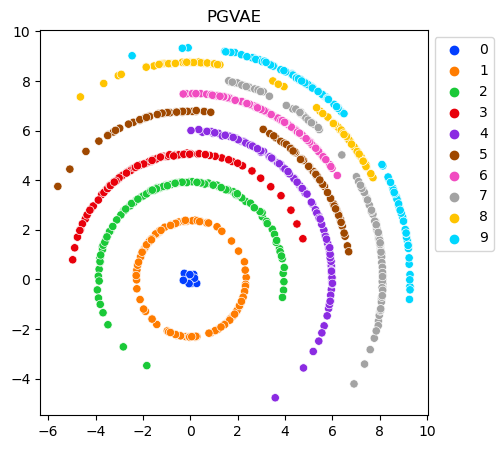

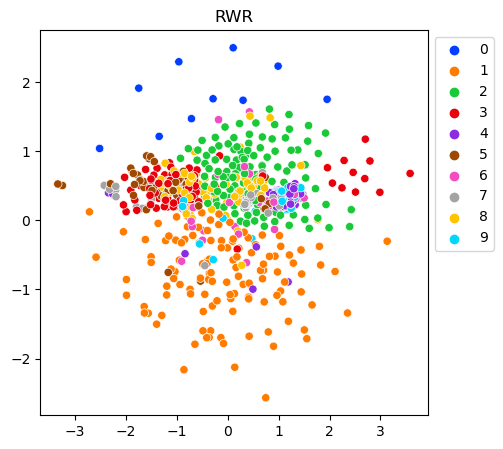

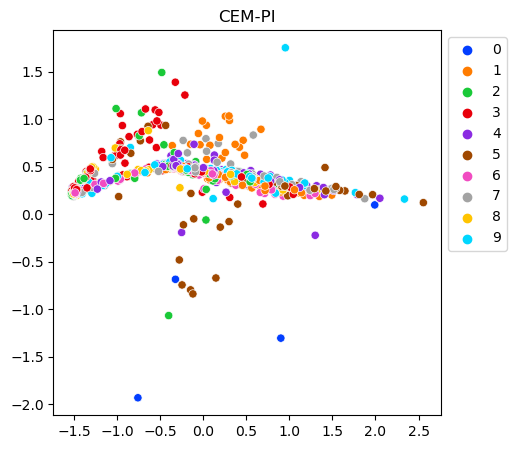

In [5]:
# Latent Spcae Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from pgvae import encode

pal_colors = sns.color_palette("bright", 10)
[c_dark_blue, c_orange, c_green, c_red, c_purple, c_brown, c_pink, c_gray, c_yellow, c_lightblue] = pal_colors

data = np.load(datadir)
lbl = data["lbl"]

# savedir = "figures"
# os.makedirs(savedir, exist_ok=True)

# iterate over the configs
method_names = ["pgvae", "rwr", "cem-pi"]
model_paths = {"pgvae": "../results/mnist_models/mnist_pgvae.pt", 
               "rwr": "../results/mnist_models/mnist_rwr.pt", 
               "cem-pi": "../results/mnist_models/mnist_cem-pi.pt"}
method_name_map = { "rwr": "RWR", "pgvae": "PGVAE", "cem-pi": "CEM-PI"}


for method_name in method_names:
    mname = method_name_map[method_name]
    model_path = model_paths[method_name]
    print(f"cfg {method_name}")
    
    dict_load = torch.load(model_path)
    encoder.load_state_dict(dict_load["encoder"])
    decoder.load_state_dict(dict_load["decoder"])
    
    ##################################
    ### Latent Space Visualization ###
    ##################################
    scale, ratio = 5., 1.
    nrows, ncols = 1, 1
    figsize = (ncols*scale*ratio, nrows*scale)
    fig_ls, axes_ls = plt.subplots(nrows, ncols, figsize=figsize, dpi=100)


    # logpz vs y
    x, y = ds.dsall["x"], ds.dsall["y"]
    bs, xs, *xd = x.shape
    nh, nw = xd

    if vae_type == "mlp":
        xdf = (np.prod(xd),)
    else:
        # for cnn, ...
        xdf = xd
        raise NotImplementedError

    x = x.reshape((bs, xs, *xdf))


    # create latent space plots
    mu, logvar = encode(x, encoder)
    mu_arr = mu.detach().cpu()[0]
    sns.scatterplot(x=mu_arr[:, 0], y=mu_arr[:, 1], hue=lbl, 
                    ax=axes_ls, palette=pal_colors)
    
    title = mname
    axes_ls.set_title(title)
    axes_ls.legend(bbox_to_anchor= (1., 1.))